## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (plus script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (as shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarifiy and explain them.
* Make sure that **number cells consecutively starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells`.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

In [ ]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Simple Data Analysis and Logistic Regression Classification 

## The `digits` dataset

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import pickle
import gzip

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns

from sklearn.datasets import load_digits

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

np.set_printoptions(precision=3)

## Loading Data

The dataset is available from scikit-learn.

In [3]:
digits = load_digits()
print("data_shape: {0}".format(digits['data'].shape))
print("data_items: {0}".format(digits.keys()))
print("feature_names:\n{0}".format(digits['feature_names']))

df = pd.DataFrame(data=digits['data'], columns=digits['feature_names'])

data_shape: (1797, 64)
data_items: dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
feature_names:
['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4', 'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1', 'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6', 'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3', 'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0', 'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5', 'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2', 'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7', 'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4', 'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1', 'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_5', 'pixel_6_6', 'pixel_6_7', 'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3', 'pixel_7_4', 'pixel_7_5', 'pixel_7_6', 'pixel_7_7']


In [4]:
digits['target']

array([0, 1, 2, ..., 8, 9, 8])

We define a new target set choosing a `target_digit` so that we can work with a 2-class problem.

In [5]:
target_digit = 9
new_targets = np.zeros(digits['target'].shape[0])
new_targets[digits['target'] == target_digit] = 1
df['target'] = new_targets

## Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms

### Descriptive analysis

In [6]:
df.describe(include='all').round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
pixel_0_0,1797.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
pixel_0_1,1797.0,0.30,0.91,0.0,0.0,0.0,0.0,8.0
pixel_0_2,1797.0,5.20,4.75,0.0,1.0,4.0,9.0,16.0
pixel_0_3,1797.0,11.84,4.25,0.0,10.0,13.0,15.0,16.0
pixel_0_4,1797.0,11.85,4.29,0.0,10.0,13.0,15.0,16.0
...,...,...,...,...,...,...,...,...
pixel_7_4,1797.0,11.81,4.93,0.0,10.0,14.0,16.0,16.0
pixel_7_5,1797.0,6.76,5.90,0.0,0.0,6.0,12.0,16.0
pixel_7_6,1797.0,2.07,4.09,0.0,0.0,0.0,2.0,16.0
pixel_7_7,1797.0,0.36,1.86,0.0,0.0,0.0,0.0,16.0


### Some examples

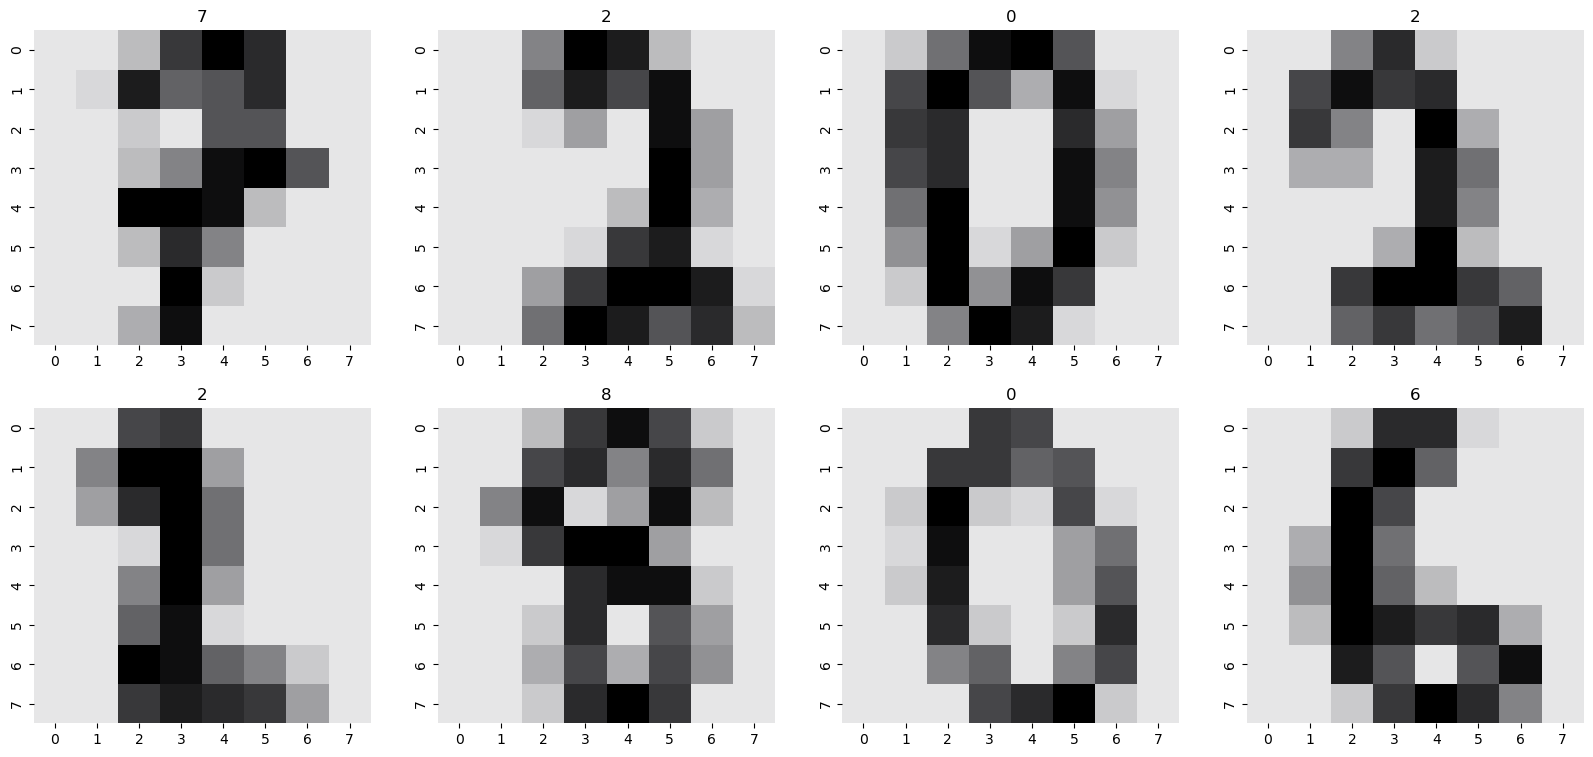

In [7]:
#n_colors = 9
#cMap = plt.cm.get_cmap("bwr", lut=n_colors ) 
cMap = sns.cubehelix_palette(n_colors=50, hue=0.05, rot=0, light=0.9, dark=0)

l_columns = digits['feature_names']
plt.figure(figsize=(20, 9))

for i in range(8):
    plt.subplot(2, 4, i+1)
    #select images randomly
    idx = np.random.randint(low=0, high=len(new_targets))
    plt.title(int(digits['target'][idx]))
    h_map = sns.heatmap(df[l_columns].iloc[idx].values.reshape(8, 8),
                    vmin=0., vmax=16., 
                    cmap=cMap, 
                    cbar=False,
                    #annot=True, 
                   )
plt.show()

### Boxplots

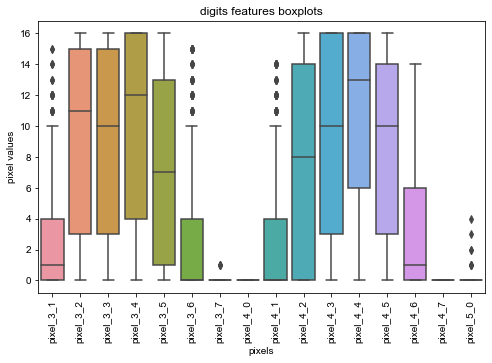

In [9]:
########## feature boxplots 
plt.figure( figsize=(8, 5))
plt.title("digits features boxplots")
sns.set_style("white")
bx_plot = sns.boxplot(data=df[df.columns[25:41]])
plt.xticks(rotation=90)
plt.xlabel("pixels")
plt.ylabel("pixel values")
plt.show()

### Histograms and scatterplots

Plot histograms of groups of all variables plus target.

We always check scatterplots and correlations, but now their relationship with the 0, 1 target is now less relevant.

### Positive vs Negative Feature Histograms

A clssification problem is more or less solvable depending on the overlap of patterns across classes.

We check this for each feature.

C:\Users\josed\miniconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


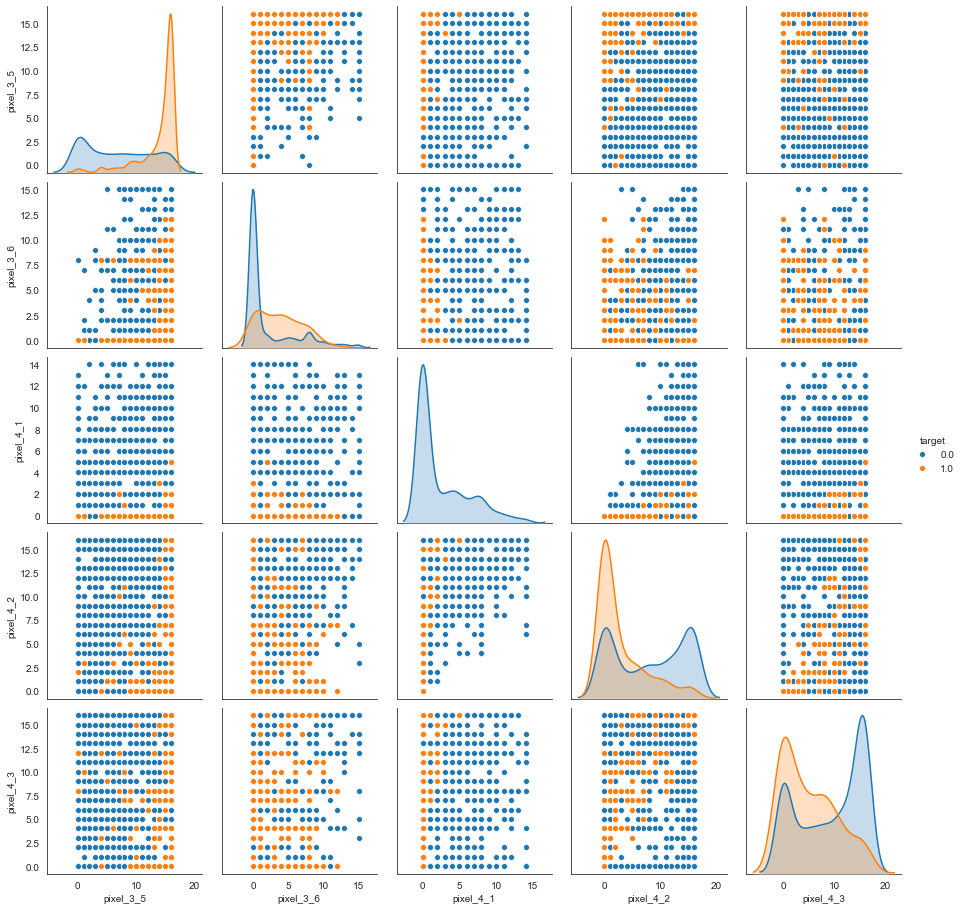

In [10]:
#we choose some features we expect to be meaningful
l_columns = ['pixel_3_5', 'pixel_3_6', 'pixel_4_1', 'pixel_4_2', 'pixel_4_3']
pair_plot = sns.pairplot(df[l_columns + ['target']], hue= 'target', diag_kind="kde", diag_kws=dict(shade=True))
plt.show()

## Correlations

We drop the `target` column.

In [11]:
df[l_columns].corr().round(decimals=3)

,pixel_3_5,pixel_3_6,pixel_4_1,pixel_4_2,pixel_4_3
pixel_3_5,1.000,0.512,0.081,-0.007,-0.257
pixel_3_6,0.512,1.000,0.383,0.283,-0.166
pixel_4_1,0.081,0.383,1.000,0.629,-0.094
pixel_4_2,-0.007,0.283,0.629,1.000,0.332
pixel_4_3,-0.257,-0.166,-0.094,0.332,1.000


Una imagen (o un heatmap) vale más que mil palabras

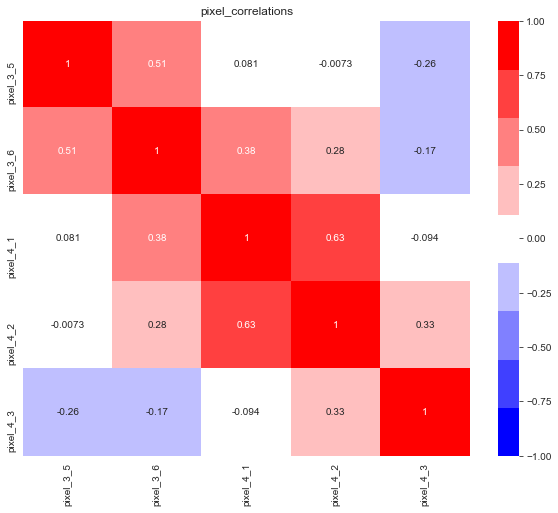

In [12]:
# definir el color map
n_colors = 9
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

# definir el heatmap
plt.figure( figsize=(10, 8))
plt.title('pixel_correlations')
h_map = sns.heatmap(df[l_columns].corr().values,
                    vmin=-1., vmax=1., 
                    cmap=cMap, 
                    annot=True, 
                    xticklabels=list(df[l_columns]),
                    yticklabels=list(df[l_columns]))
plt.xticks(rotation=90) 

# generar el dibujo
plt.show()

## k-NN Classification

Vamos a probar un modelo alternativo

In [13]:
x = digits['data']
y = new_targets

knn_classifier = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('knn', KNeighborsClassifier(weights='distance'))])

knn_classifier.fit(x, y) 

y_pred = knn_classifier.predict(x)

acc    = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
prec   = precision_score(y, y_pred) 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))

print("\nconfusion matrix:\n", confusion_matrix(y, y_pred))

acc: 1.000	recall: 1.000	precision: 1.000

confusion matrix:
 [[1617    0]
 [   0  180]]


### Grid Search of Optimal Number of neighbors

In [14]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

# we use stratified folds
n_folds = 10
skf = StratifiedKFold(n_folds, 
                      shuffle=True)

l_k = [1] + [1 + 2**k for k in range(0, 6)]
param_grid = {'knn__n_neighbors': l_k}

knn_gscv = GridSearchCV(knn_classifier, 
                        param_grid=param_grid, 
                        cv=skf, 
                        scoring='accuracy', 
                        return_train_score=True, 
                        n_jobs=-1, 
                        verbose=1)

print("GridSearch over a list of neighbors: {0}".format(l_k))
_ = knn_gscv.fit(x, y)

GridSearch over a list of neighbors: [1, 2, 3, 5, 9, 17, 33]
Fitting 10 folds for each of 7 candidates, totalling 70 fits


### Search Results Analysis

Comprobamos los parámetros de los mejores modelos.

In [15]:
df_nn_k_search = pd.DataFrame.from_dict(knn_gscv.cv_results_)

display(df_nn_k_search[["param_knn__n_neighbors", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_knn__n_neighbors,mean_test_score
5,17,0.991654
4,9,0.991651
3,5,0.991096
2,3,0.990540
0,1,0.988315


Dibujamos todos los scores.

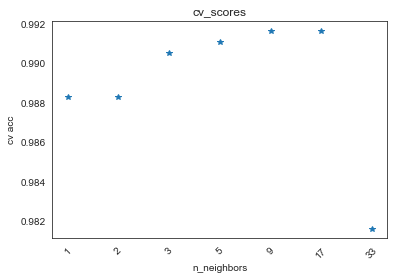

In [16]:
plt.title("cv_scores")
plt.xlabel('n_neighbors')
plt.ylabel('cv acc')
plt.xticks(range(len(l_k)), l_k, rotation=45)
_ = plt.plot( df_nn_k_search['mean_test_score'], '*')
plt.show()

### Accuracy, Precision y Recall 

In [17]:
best_k = knn_gscv.best_params_['knn__n_neighbors']

print("best_k: {0:d}".format(best_k))

# accuracies
acc_cv_scores = cross_val_score(knn_gscv.best_estimator_, 
                                x, 
                                y, 
                                cv=skf, 
                                scoring='accuracy')

print ("acc_cv_scores:\n\t", acc_cv_scores)
print("\n\tcv_acc_mean: %.3f\n" % (acc_cv_scores.mean()))

# recall
recall_cv_scores = cross_val_score(knn_gscv.best_estimator_, 
                                   x, 
                                   y, 
                                   cv=skf, 
                                   scoring='recall')
print ("recall_cv_scores:\n\t", recall_cv_scores)
print("\n\tcv_recall_mean: %.3f\n" % (recall_cv_scores.mean()))

# precision
prec_cv_scores = cross_val_score(knn_gscv.best_estimator_,
                                 x, 
                                 y, 
                                 cv=skf, 
                                 scoring='precision')
print ("precision_cv_scores:\n\t", prec_cv_scores)
print("\n\tcv_precisison_mean: %.3f\n" % (prec_cv_scores.mean()))

best_k: 17
acc_cv_scores:
	 [0.983 0.989 0.978 1.    0.989 0.994 0.983 1.    0.983 0.994]

	cv_acc_mean: 0.989

recall_cv_scores:
	 [0.889 0.944 0.833 0.889 1.    0.944 0.889 1.    0.944 0.944]

	cv_recall_mean: 0.928

precision_cv_scores:
	 [0.944 1.    1.    1.    1.    1.    0.944 1.    1.    0.947]

	cv_precisison_mean: 0.984



## Logistic Regression

Just getting started ...

We first run a single model over all data and then explore CV.

In all cases we use l2 penalty, the newton-cg solver and a penalty C=1.

b: -9.676005


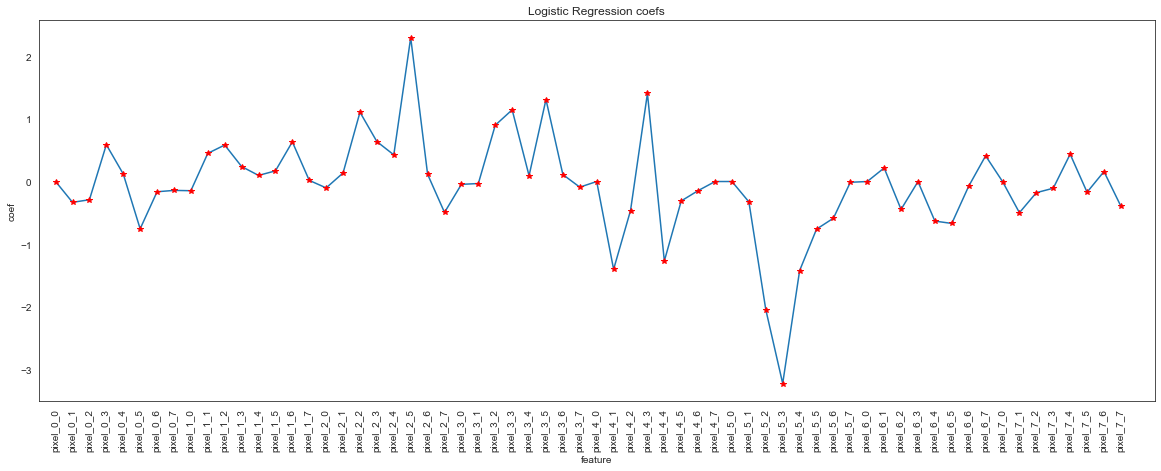

In [18]:
########## build a first log regression model
logr_classifier = Pipeline(steps=[('std_sc', StandardScaler()),
                                  ('logr', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000))])

# fit sobre la muestra completa, sin split train-test
logr_classifier.fit(x, y)

print("b: %f" % logr_classifier[1].intercept_)

nticks_coefs = x.shape[1]
plt.figure(figsize=(20, 7))
plt.title('Logistic Regression coefs')
plt.xlabel('feature')
plt.ylabel('coef')
plt.xlim(-1, nticks_coefs+1)
#plt.ylim(-1., 1.)
plt.xticks(range(nticks_coefs), digits['feature_names'], rotation='vertical')
_ = plt.plot(logr_classifier[1].coef_.reshape( x.shape[1] ), '-', logr_classifier[1].coef_.reshape( x.shape[1] ), 'r*')

### CV estimates of accuracy, recall, precision and confusion matrix

In [19]:
n_folds = 10
skf = StratifiedKFold(n_folds, 
                      shuffle=True)

# accuracies
y_pred = cross_val_predict(logr_classifier,
                           x,
                           y,
                           cv=skf)

acc    = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
prec   = precision_score(y, y_pred) 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))

print("\nconfusion matrix:\n", confusion_matrix(y, y_pred))

acc: 0.985	recall: 0.894	precision: 0.953

confusion matrix:
 [[1609    8]
 [  19  161]]


## Tuning `C` in Logistic Regression

We select the log regression regularization parameter `C` by CV using sklearn randomized search

**Note**: `C` penalizes $\|w\|^2$ basically as `1./alpha`

We estimate the optimal `C` again by CV.

In [20]:
n_folds = 10
skf = StratifiedKFold(n_folds, 
                      shuffle=True)

l_C = [10.**k for k in range(-6, 10)]
param_grid = {'logr__C': l_C}


# we use GridSearchCV which uses by default stratified folds
logr_gscv = GridSearchCV(logr_classifier, 
                            param_grid=param_grid, 
                            cv=skf, 
                            scoring='accuracy', 
                            return_train_score=True, 
                            n_jobs=-1, 
                            verbose=1)
_ = logr_gscv.fit(x, y)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


### Analyzing the CV results

We plot the CV errors with respect to `C` to check on the adequacy of the best hyperparameter.

We check the best model hyperparameters.

In [21]:
df_cv_estimator = pd.DataFrame.from_dict(logr_gscv.cv_results_)

display(df_cv_estimator[["param_logr__C", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_logr__C,mean_test_score
6,1,0.984429
5,0.1,0.982197
7,10,0.979978
8,100,0.978309
9,1000,0.972737


best C: 1.0000 	acc: 0.984


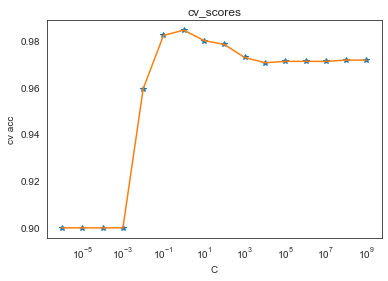

In [22]:
best_C = logr_gscv.best_params_['logr__C']
print("best C: %.4f" % (best_C), 
      "\tacc: %.3f" % logr_gscv.best_score_) 

plt.title("cv_scores")
plt.xlabel('C')
plt.ylabel('cv acc')
plt.xscale('log')
_ = plt.plot( df_cv_estimator['param_logr__C'], df_cv_estimator['mean_test_score'], '*',
              df_cv_estimator['param_logr__C'], df_cv_estimator['mean_test_score'], '-')

### Analyzing the performance of the best hyperparameter

In [23]:
### CV accuracy, recall and precision of best model
y_pred = cross_val_predict(logr_gscv.best_estimator_, x, y, cv=skf, n_jobs=2)

acc    = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
prec   = precision_score(y, y_pred) 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))

print("\nconfusion matrix:\n", confusion_matrix(y, y_pred))

acc: 0.987	recall: 0.906	precision: 0.964

confusion matrix:
 [[1611    6]
 [  17  163]]


## Predicting probabilities

In classification we should give class probability estimates rather than labels.

In [24]:
######### plot prob histograms
p_pred_log_r = cross_val_predict(logr_gscv.best_estimator_, x, y, cv=skf,
                                 method='predict_proba')

We build the histogram of the posterior probabilities predicted for the positive class and decide on adequate thresholds.

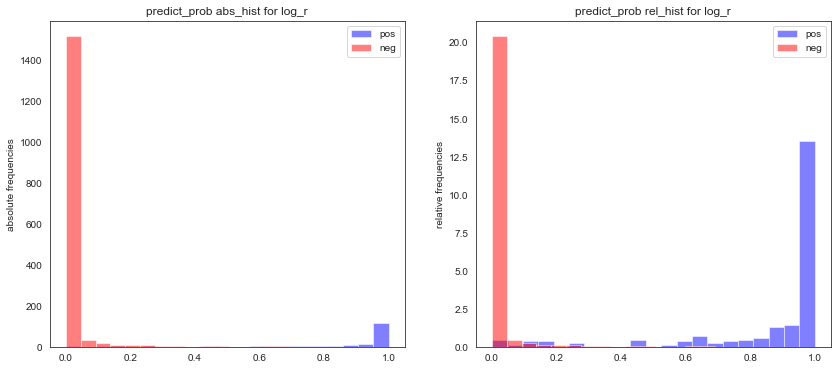

In [25]:
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]

bins = 21

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("predict_prob abs_hist for log_r")
plt.ylabel("absolute frequencies")
plt.hist( p_pred_log_r[pos, 1], bins=bins, density=False, color='b', label='pos', alpha=0.5)
plt.hist( p_pred_log_r[neg, 1], bins=bins, density=False, color='r', label='neg', alpha=0.5)
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title("predict_prob rel_hist for log_r")
plt.ylabel("relative frequencies")
plt.hist( p_pred_log_r[pos, 1], bins=bins, density=True, color='b', label='pos', alpha=0.5)
plt.hist( p_pred_log_r[neg, 1], bins=bins, density=True, color='r', label='neg', alpha=0.5)
#sns.distplot( p_pred_log_r[pos, 1], bins=bins, norm_hist=True, kde=False, color='b', label='pos')
#sns.distplot( p_pred_log_r[neg, 1], bins=bins, norm_hist=True, kde=False, color='r', label='neg')
plt.legend(loc='best')

plt.show()

### Applying classification models

We explore the effect on the classification performance of lowering the decision threshold for positives below 0.5.

In [26]:
######### threshold analysis
num_patterns = x.shape[0]
l_thresholds = [0.5, 0.4, 0.3, 0.2]

for thresh in l_thresholds:
    y_pred_thresh = np.zeros( num_patterns ) 
    pos_thresh = np.where(p_pred_log_r[ :, 1] > thresh)[0]
    y_pred_thresh[pos_thresh] = 1

    print("threshold:", thresh)
    print("confusion matrix\n", confusion_matrix(y, y_pred_thresh) )
    print("\n\taccuracy\t%.3f"    %   accuracy_score(y, y_pred_thresh) )
    print("\trecall\t\t%.3f"      %   recall_score(y, y_pred_thresh) )
    print("\tprecision\t%.3f"     %   precision_score(y, y_pred_thresh) )
    print("\tnum_alertas\t%d\n\n" %   confusion_matrix(y, y_pred_thresh)[ : , 1 ].sum() )    

threshold: 0.5
confusion matrix
 [[1608    9]
 [  17  163]]

	accuracy	0.986
	recall		0.906
	precision	0.948
	num_alertas	172


threshold: 0.4
confusion matrix
 [[1604   13]
 [  13  167]]

	accuracy	0.986
	recall		0.928
	precision	0.928
	num_alertas	180


threshold: 0.3
confusion matrix
 [[1598   19]
 [  13  167]]

	accuracy	0.982
	recall		0.928
	precision	0.898
	num_alertas	186


threshold: 0.2
confusion matrix
 [[1581   36]
 [  11  169]]

	accuracy	0.974
	recall		0.939
	precision	0.824
	num_alertas	205




## MLP Classifier

In [27]:
mlp_classifier = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('mlpc', MLPClassifier(solver='adam', 
                                              hidden_layer_sizes=(1,),
                                              activation='identity',
                                              alpha=1.,
                                              tol=1.e-4, 
                                              max_iter=1000,
                                              warm_start=False,
                                              shuffle=True))])
_ = mlp_classifier.fit(x, y)
y_mlpc_pred = mlp_classifier.predict(x)

In [28]:
logr_c = Pipeline(steps=[('std_sc', StandardScaler()),
                         ('logr', LogisticRegression(solver='lbfgs', C= 1., penalty='l2', max_iter=1000))])

_ = logr_c.fit(x, y)
y_logr_c_pred = logr_c.predict(x)

In [29]:
print((y_mlpc_pred - y_logr_c_pred).std())

(y_mlpc_pred != y_logr_c_pred).sum()

0.05274566771763066


5

### CV Hyperparametrization

In [31]:
n_folds = 10
skf = StratifiedKFold(n_folds, shuffle=True)

mlp_classifier = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('mlpc', MLPClassifier(solver='adam', 
                                              activation='relu',
                                              tol=1.e-4, 
                                              max_iter=1000,
                                              warm_start=False,
                                              shuffle=True))])

l_hidden_layer_sizes = [(20,), (20, 20)]
l_alpha = [10.**k for k in range(-6, 4)]

param_grid = {'mlpc__alpha': l_alpha, 'mlpc__hidden_layer_sizes': l_hidden_layer_sizes}

mlpc_gscv = GridSearchCV(mlp_classifier, 
                         param_grid=param_grid, 
                         cv=skf, 
                         scoring='accuracy', 
                         return_train_score=True, 
                         n_jobs=-1, 
                         verbose=1)

t_0 = time.time() 
_ = mlpc_gscv.fit(x, y)
t_1 = time.time() 
print("\nmlp_grid_search_time: {0:.2}f".format((t_1 - t_0)/60.))

# saving alpha_search in a pickle    
joblib.dump(mlpc_gscv, 'mlp_classifier_gscv.joblib')

Fitting 10 folds for each of 20 candidates, totalling 200 fits

mlp_grid_search_time: 1.7f


['mlp_classifier_gscv.joblib']

### Analyzing the CV results

We check first the best models' params.

In [32]:
df_cv_estimator = pd.DataFrame.from_dict(mlpc_gscv.cv_results_)

display(df_cv_estimator[["param_mlpc__alpha", "param_mlpc__hidden_layer_sizes", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_mlpc__alpha,param_mlpc__hidden_layer_sizes,mean_test_score
10,0.1,"(20,)",0.995552
7,0.001,"(20, 20)",0.994994
2,1e-05,"(20,)",0.993886
3,1e-05,"(20, 20)",0.993883
4,0.0001,"(20,)",0.993330


We plot the CV errors to check on the adequacy of the best hyperparameter.

best alpha: 0.100000	
alpha_min: 0.000001	alpha_max: 1000.000000
best_hidden_layer_sizes (20,) 
acc: 0.996


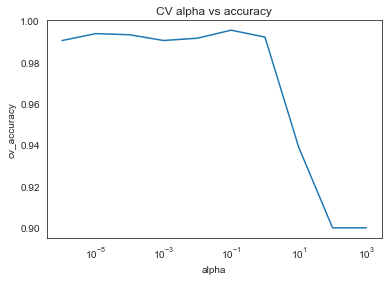

In [33]:
mlpc_gscv = joblib.load('mlp_classifier_gscv.joblib')

best_alpha = mlpc_gscv.best_params_['mlpc__alpha'] 
print("best alpha: %.6f\t" % best_alpha)
print("alpha_min: %f\talpha_max: %f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))

best_hidden_layer_sizes = mlpc_gscv.best_params_['mlpc__hidden_layer_sizes'] 
print("best_hidden_layer_sizes", best_hidden_layer_sizes, "\nacc: %.3f" % mlpc_gscv.best_score_) 

idx_best_hidden_layer_sizes = [tup == best_hidden_layer_sizes for tup in df_cv_estimator['param_mlpc__hidden_layer_sizes'].values]
idx_best_hidden_layer_sizes = np.array(idx_best_hidden_layer_sizes)

plt.title("CV alpha vs accuracy")
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("cv_accuracy")
_ = plt.plot( df_cv_estimator[idx_best_hidden_layer_sizes]['param_mlpc__alpha'], 
              df_cv_estimator[idx_best_hidden_layer_sizes]['mean_test_score'])

And check classifier performance

In [34]:
### CV accuracy, recall and precision of best model
y_pred = cross_val_predict(mlpc_gscv.best_estimator_, x, y, cv=skf, n_jobs=2)

acc    = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
prec   = precision_score(y, y_pred) 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))

print("\nconfusion matrix:\n", confusion_matrix(y, y_pred))

acc: 0.992	recall: 0.939	precision: 0.983

confusion matrix:
 [[1614    3]
 [  11  169]]


## Predicting probabilities

We compute class probabilities and compare them with those obtained with logistic regression.

In [35]:
p_pred_mlp = cross_val_predict(mlpc_gscv.best_estimator_, x, y, 
                               cv=skf,
                               method='predict_proba')

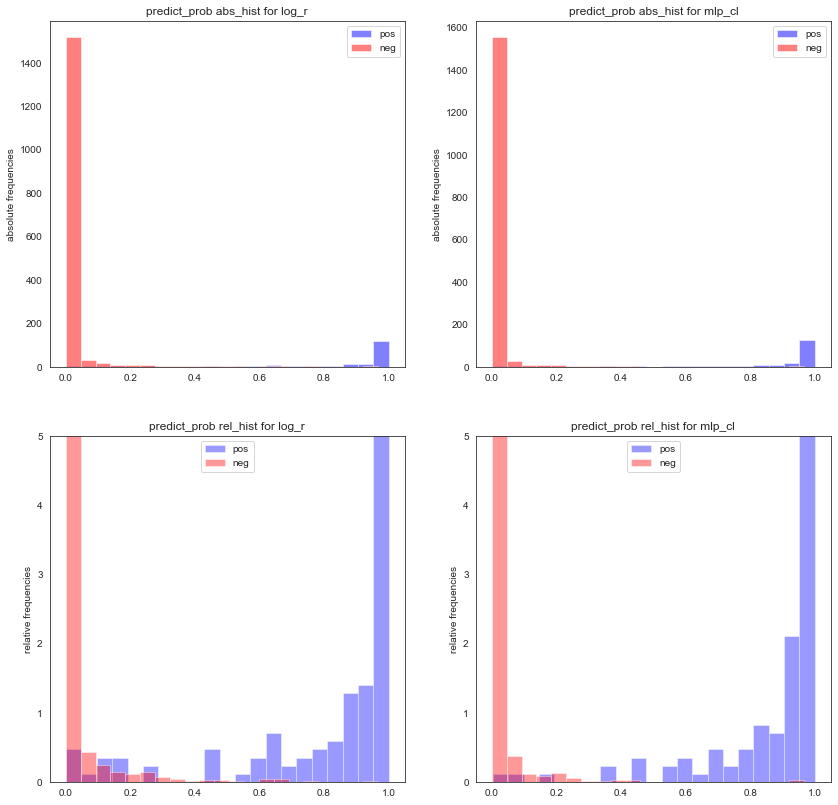

In [36]:
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]

bins = 21

plt.figure(figsize=(14, 14))

# first log_r
plt.subplot(2, 2, 1)
plt.title("predict_prob abs_hist for log_r")
plt.ylabel("absolute frequencies")
#plt.ylim(0., 100.)
plt.hist( p_pred_log_r[pos, 1], bins=bins, density=False, color='b', label='pos', alpha=0.5)
plt.hist( p_pred_log_r[neg, 1], bins=bins, density=False, color='r', label='neg', alpha=0.5)
plt.legend(loc='best')

plt.subplot(2, 2, 3)
plt.title("predict_prob rel_hist for log_r")
plt.ylabel("relative frequencies")
plt.ylim(0., 5.)
sns.distplot( p_pred_log_r[pos, 1], bins=bins, norm_hist=True, kde=False, color='b', label='pos')
sns.distplot( p_pred_log_r[neg, 1], bins=bins, norm_hist=True, kde=False, color='r', label='neg')
plt.legend(loc='best')

# now log_r
plt.subplot(2, 2, 2)
plt.title("predict_prob abs_hist for mlp_cl")
plt.ylabel("absolute frequencies")
#plt.ylim(0., 100.)
plt.hist( p_pred_mlp[pos, 1], bins=bins, density=False, color='b', label='pos', alpha=0.5)
plt.hist( p_pred_mlp[neg, 1], bins=bins, density=False, color='r', label='neg', alpha=0.5)
plt.legend(loc='best')

plt.subplot(2, 2, 4)
plt.title("predict_prob rel_hist for mlp_cl")
plt.ylabel("relative frequencies")
plt.ylim(0., 5.)
sns.distplot( p_pred_mlp[pos, 1], bins=bins, norm_hist=True, kde=False, color='b', label='pos')
sns.distplot( p_pred_mlp[neg, 1], bins=bins, norm_hist=True, kde=False, color='r', label='neg')
plt.legend(loc='best')

plt.show()

### Applying classification models

We examine model performance for different thresholds.

In [37]:
######### threshold analysis
num_patterns = x.shape[0]
l_thresholds = [0.5, 0.4, 0.3, 0.2]

for thresh in l_thresholds:
    y_pred_thresh = np.zeros( num_patterns ) 
    pos_thresh = np.where(p_pred_mlp[ :, 1] > thresh)[0]
    y_pred_thresh[pos_thresh] = 1

    print("threshold:", thresh)
    print("confusion matrix\n", confusion_matrix(y, y_pred_thresh) )
    print("\n\taccuracy\t%.3f"    %   accuracy_score(y, y_pred_thresh) )
    print("\trecall\t\t%.3f"      %   recall_score(y, y_pred_thresh) )
    print("\tprecision\t%.3f"     %   precision_score(y, y_pred_thresh) )
    print("\tnum_alertas\t%d\n\n" %   confusion_matrix(y, y_pred_thresh)[ : , 1 ].sum() )

threshold: 0.5
confusion matrix
 [[1615    2]
 [   8  172]]

	accuracy	0.994
	recall		0.956
	precision	0.989
	num_alertas	174


threshold: 0.4
confusion matrix
 [[1613    4]
 [   5  175]]

	accuracy	0.995
	recall		0.972
	precision	0.978
	num_alertas	179


threshold: 0.3
confusion matrix
 [[1610    7]
 [   3  177]]

	accuracy	0.994
	recall		0.983
	precision	0.962
	num_alertas	184


threshold: 0.2
confusion matrix
 [[1602   15]
 [   3  177]]

	accuracy	0.990
	recall		0.983
	precision	0.922
	num_alertas	192




## Multiclass

We work now with the original targets in a 10-class problem.

In [38]:
x = digits['data']
y = digits['target']

n_folds = 10
skf = StratifiedKFold(n_folds, shuffle=True)

mlp_classifier = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('mlpc', MLPClassifier(solver='adam', 
                                              activation='relu',
                                              tol=1.e-4, 
                                              max_iter=1000,
                                              warm_start=False,
                                              shuffle=True))])

l_hidden_layer_sizes = [(20,), (20, 20)]
l_alpha = [10.**k for k in range(-6, 4)]

param_grid = {'mlpc__alpha': l_alpha, 'mlpc__hidden_layer_sizes': l_hidden_layer_sizes}

mlp_mc_gscv = GridSearchCV(mlp_classifier, 
                         param_grid=param_grid, 
                         cv=skf, 
                         scoring='accuracy', 
                         return_train_score=True, 
                         n_jobs=-1, 
                         verbose=1)

t_0 = time.time() 
_ = mlp_mc_gscv.fit(x, y)
t_1 = time.time() 
print("\nmlp_grid_search_time: {0:.2}f".format((t_1 - t_0)/60.))

# saving alpha_search in a pickle    
joblib.dump(mlp_mc_gscv, 'mlp_mc_classifier_gscv.joblib')

Fitting 10 folds for each of 20 candidates, totalling 200 fits

mlp_grid_search_time: 2.5f


['mlp_mc_classifier_gscv.joblib']

### Analyzing the CV results

We plot the CV errors with respect to `C` to check on the adequacy of the best hyperparameter.

In [39]:
df_mc_cv_estimator = pd.DataFrame.from_dict(mlp_mc_gscv.cv_results_)

display(df_mc_cv_estimator[["param_mlpc__alpha", "param_mlpc__hidden_layer_sizes", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_mlpc__alpha,param_mlpc__hidden_layer_sizes,mean_test_score
10,0.1,"(20,)",0.973842
12,1,"(20,)",0.973836
11,0.1,"(20, 20)",0.973277
13,1,"(20, 20)",0.972728
5,0.0001,"(20, 20)",0.971620


best alpha: 0.100000	
alpha_min: 0.000001	alpha_max: 1000.000000
best_hidden_layer_sizes (20,) 
acc: 0.996


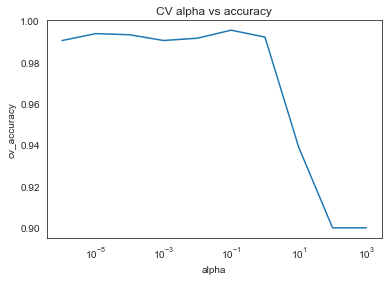

In [40]:
mlp_mc_gscv = joblib.load('mlp_classifier_gscv.joblib')

best_alpha = mlp_mc_gscv.best_params_['mlpc__alpha'] 
print("best alpha: %.6f\t" % best_alpha)
print("alpha_min: %f\talpha_max: %f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))

best_hidden_layer_sizes = mlp_mc_gscv.best_params_['mlpc__hidden_layer_sizes'] 
print("best_hidden_layer_sizes", best_hidden_layer_sizes, "\nacc: %.3f" % mlpc_gscv.best_score_) 

idx_best_hidden_layer_sizes = [tup == best_hidden_layer_sizes for tup in df_cv_estimator['param_mlpc__hidden_layer_sizes'].values]
idx_best_hidden_layer_sizes = np.array(idx_best_hidden_layer_sizes)

plt.title("CV alpha vs accuracy")
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("cv_accuracy")
_ = plt.plot( df_cv_estimator[idx_best_hidden_layer_sizes]['param_mlpc__alpha'], 
              df_cv_estimator[idx_best_hidden_layer_sizes]['mean_test_score'])

### Analyzing the performance of the best hyperparameter

And check classifier performance

In [41]:
### CV accuracy, recall and precision of best model
y_pred = cross_val_predict(mlp_mc_gscv.best_estimator_, x, y, cv=skf, n_jobs=2)

acc    = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred, average='micro')
prec   = precision_score(y, y_pred, average='micro') 

print("acc: %.3f\trecall: %.3f\tprecision: %.3f" % (acc, recall, prec))

print("\nconfusion matrix:\n", confusion_matrix(y, y_pred))

acc: 0.975	recall: 0.975	precision: 0.975

confusion matrix:
 [[175   0   1   0   1   0   1   0   0   0]
 [  0 179   0   0   1   0   0   0   1   1]
 [  0   2 174   0   0   0   0   0   1   0]
 [  0   0   0 178   0   1   0   0   3   1]
 [  0   1   0   0 177   0   0   1   0   2]
 [  0   0   0   1   0 177   1   1   0   2]
 [  0   1   0   0   0   1 178   0   1   0]
 [  0   1   0   0   0   0   0 177   0   1]
 [  0   4   1   0   0   0   1   1 166   1]
 [  0   0   0   2   0   2   0   1   4 171]]
